# Predict weekly data, single city

In [73]:
import os
from pathlib import Path
from prophet import Prophet

import torch, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from data.india_pollution import india_pollution
from data.stock_prices import stock_prices
from data.list_of_tuples import list_of_tuples

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option("display.width", 140)

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [60]:
chosen_name = "Bengaluru"
# chosen_name = "JPM
# chosen_name = "linear + noise"

# input_dataframe, time_unit, number_columns = list_of_tuples(200)
# input_dataframe, time_unit, number_columns = stock_prices(chosen_name)
input_dataframe, time_unit, number_columns = india_pollution(city=[chosen_name])

chosen_variable = number_columns[0]

display(input_dataframe.head())
input_dataframe.describe(include=(np.number))

Path air-quality-data-in-india exists


,PM2.5,PM10,O3,CO,SO2,NO2
Date,,,,,,
2015-01-04,30.65,70.46,15.807500,6.032500,6.910000,19.637500
2015-01-11,30.65,70.46,16.888571,1.561429,6.492857,27.168571
2015-01-18,30.65,70.46,16.485714,6.827143,13.562857,22.660000
2015-01-25,30.65,70.46,41.432564,6.372857,42.478571,12.630000
2015-02-01,30.65,70.46,21.145714,2.301429,10.921429,13.434286


,PM2.5,PM10,O3,CO,SO2,NO2
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,35.931781,81.351225,33.339421,1.842274,5.513256,27.929567
std,17.395080,30.741989,16.138142,2.854199,3.064122,11.466776
min,11.872857,21.125714,4.005714,0.298571,1.615714,6.667143
25%,22.659886,62.066071,19.349406,0.769286,3.955357,19.324286
50%,32.567857,70.460000,31.428571,0.950714,5.197857,27.894286
75%,43.567143,98.357143,44.760449,1.185714,6.392857,34.370000
max,149.989207,208.570000,78.690000,22.202857,42.478571,77.882857


In [61]:
print(input_dataframe.isna().sum())

PM2.5    0
PM10     0
O3       0
CO       0
SO2      0
NO2      0
dtype: int64


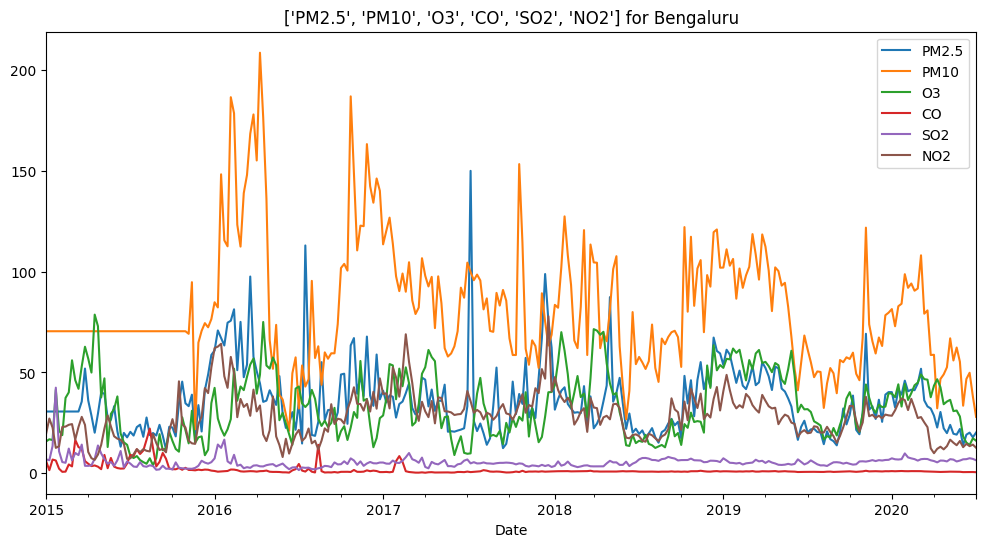

In [62]:
input_dataframe.plot(figsize=(12, 6))
plt.title(f"{number_columns} for {chosen_name}")
plt.show()

In [63]:
df_with_date_column = input_dataframe.reset_index()
df_with_date_column.head()

,Date,PM2.5,PM10,O3,CO,SO2,NO2
0,2015-01-04,30.65,70.46,15.807500,6.032500,6.910000,19.637500
1,2015-01-11,30.65,70.46,16.888571,1.561429,6.492857,27.168571
2,2015-01-18,30.65,70.46,16.485714,6.827143,13.562857,22.660000
3,2015-01-25,30.65,70.46,41.432564,6.372857,42.478571,12.630000
4,2015-02-01,30.65,70.46,21.145714,2.301429,10.921429,13.434286


In [64]:
nobs = int(len(df_with_date_column) // 5)
train = df_with_date_column[:-nobs]
test = df_with_date_column[-nobs:]

print(
    f"Length of dataframe: {len(df_with_date_column)}\n"
    f"Length of train set: {len(train)}\n"
    f"Length of test set: {len(test)}"
)

Length of dataframe: 288
Length of train set: 231
Length of test set: 57


In [65]:
forecaster = Prophet()
forecaster.fit(train.rename(columns={"Date": "ds", chosen_variable: "y"}))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.85788


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       413.498   2.27747e-06       77.8446      0.6053      0.6053      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       414.314   7.58713e-06       65.6848      0.2786      0.7748      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       414.315   8.11839e-09       67.6312      0.3862      0.3862      306   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [66]:
import datetime

if time_unit == "days":
    number_of_days = 1
elif time_unit == "weeks":
    number_of_days = 7


# construct a dataframe with the future dates
n_future_timesteps = nobs

begin_ds = train.Date.max()
print(begin_ds)
end_ds = begin_ds + datetime.timedelta(days=number_of_days * n_future_timesteps)
print(end_ds)
current_ds = begin_ds
future_dates = []
for i in range(n_future_timesteps):
    current_ds += datetime.timedelta(days=number_of_days)
    future_dates.append(current_ds)
future_dates = pd.to_datetime(future_dates)

print(future_dates)

2019-06-02 00:00:00
2020-07-05 00:00:00
DatetimeIndex(['2019-06-09', '2019-06-16', '2019-06-23', '2019-06-30', '2019-07-07', '2019-07-14', '2019-07-21', '2019-07-28',
               '2019-08-04', '2019-08-11', '2019-08-18', '2019-08-25', '2019-09-01', '2019-09-08', '2019-09-15', '2019-09-22',
               '2019-09-29', '2019-10-06', '2019-10-13', '2019-10-20', '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17',
               '2019-11-24', '2019-12-01', '2019-12-08', '2019-12-15', '2019-12-22', '2019-12-29', '2020-01-05', '2020-01-12',
               '2020-01-19', '2020-01-26', '2020-02-02', '2020-02-09', '2020-02-16', '2020-02-23', '2020-03-01', '2020-03-08',
               '2020-03-15', '2020-03-22', '2020-03-29', '2020-04-05', '2020-04-12', '2020-04-19', '2020-04-26', '2020-05-03',
               '2020-05-10', '2020-05-17', '2020-05-24', '2020-05-31', '2020-06-07', '2020-06-14', '2020-06-21', '2020-06-28',
               '2020-07-05'],
              dtype='datetime64[ns]', fre

In [67]:
future = pd.DataFrame({"ds": future_dates})

forecast = forecaster.predict(future)

forecast.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-09,39.279011,7.149303,46.345647,39.279011,39.279011,-13.292586,-13.292586,-13.292586,-13.292586,-13.292586,-13.292586,0.0,0.0,0.0,25.986425
1,2019-06-16,39.286569,2.643466,41.738554,39.286562,39.286612,-16.179336,-16.179336,-16.179336,-16.179336,-16.179336,-16.179336,0.0,0.0,0.0,23.107233
2,2019-06-23,39.294128,2.887578,43.173438,39.293024,39.295407,-15.427200,-15.427200,-15.427200,-15.427200,-15.427200,-15.427200,0.0,0.0,0.0,23.866928


In [68]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
52,2020-06-07,27.025040,7.257111,46.227185
53,2020-06-14,23.853708,5.327267,44.498393
54,2020-06-21,23.707202,3.935736,43.638137
55,2020-06-28,29.408374,10.125310,49.268030
56,2020-07-05,39.294571,20.018370,59.142848


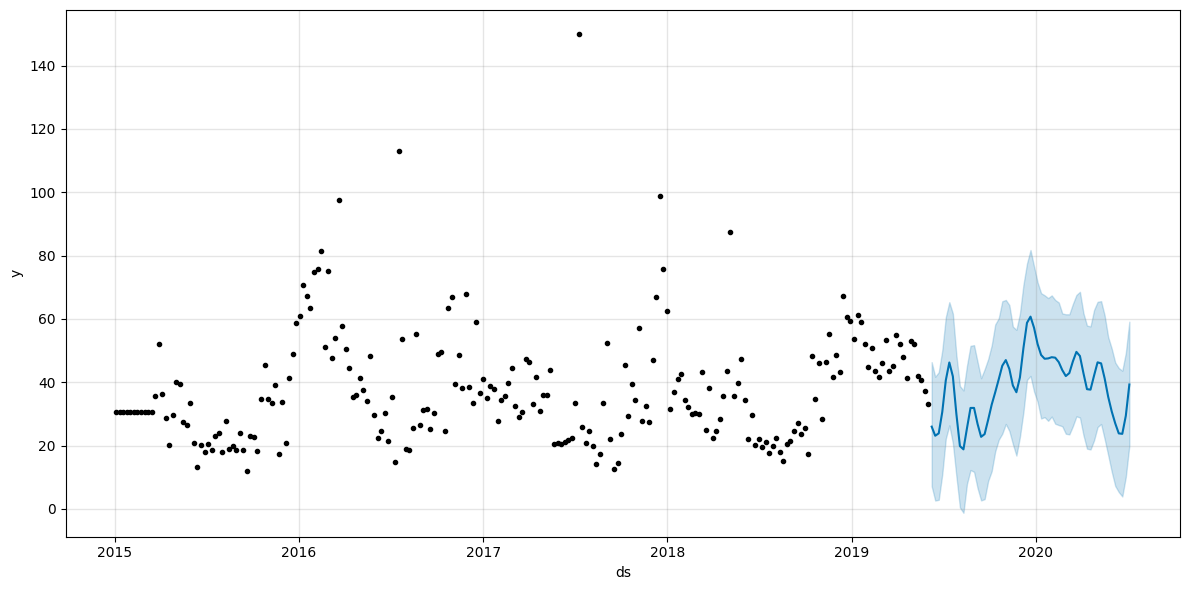

In [69]:
forecaster.plot(forecast, figsize=(12, 6))
plt.show()

## Comparing predictions to actual values

In [70]:
import matplotlib.pyplot as plt
from plots.comparison_plot import comparison_plot

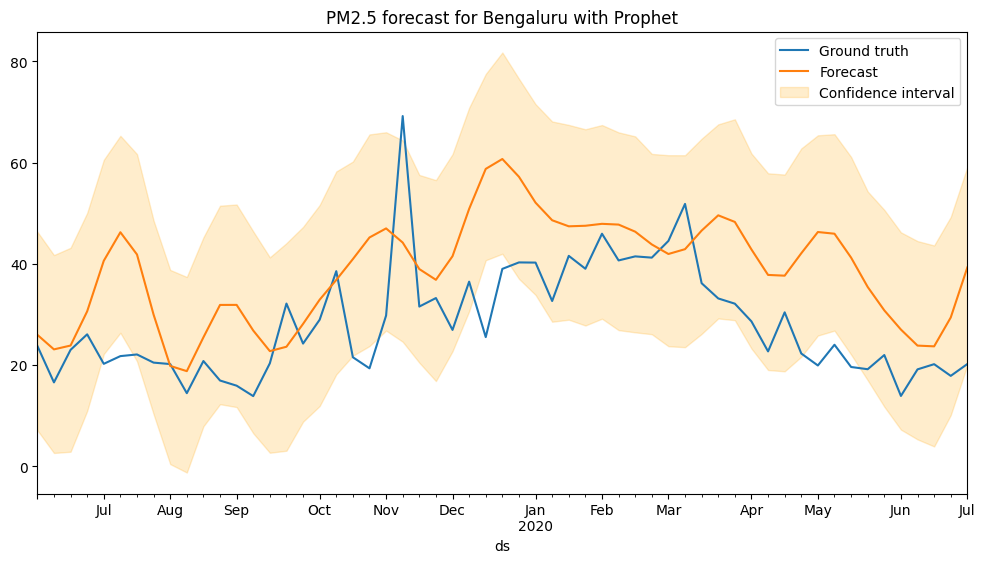

In [71]:
forecast_df = forecast.set_index(keys=["ds"]).iloc[-nobs:, :]
ground_truth_df = test.rename(columns={"Date": "ds", chosen_variable: "y"}).set_index(
    keys=["ds"]
)

# plot the ground truth and the forecast with confidence intervals

figure = comparison_plot(
    ground_truth_df["y"],
    forecast_df["yhat"],
    forecast_df.loc[:, ["yhat_lower", "yhat_upper"]],
    f"{chosen_variable} forecast for {chosen_name} with Prophet",
)

In [72]:
from measurements.get_metrics import get_metrics

get_metrics(ground_truth_df["y"], forecast_df["yhat"])

{'root_mean_squared_error': 14.2326,
 'r_squared': -0.7398,
 'mean_absolute_error': 11.8866}

In [ ]:
#TODO: take single year's data, make prediction, then 2 years etc. (which timespan gives best prediction?)
#TODO: try a prediction for 2023 (each Indian city)
#TODO: Plot weekly prediction for each city
# consdier location in country also

# External datasets as well - wind speed / direction & temperature
# Which method performs best with Pollution data
# Which metrics to use to find which method perform the best